In [1]:
import os
os.chdir('../')
# esse comando é melhor do que sys.path.insert(0, '../') pois permite interagir com arquivos do diretorio acima

In [2]:
import pickle
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 167) # opcional, questão de visualização para debugar caso 1

In [3]:
from pynnystock.FileManager import FileManager
from pynnystock.Ativo import Ativo
from pynnystock.Parameters import Parameters
from pynnystock.StatsGatherer import StatsGatherer
from pynnystock.StratsMaestro import StratsMaestro
from pynnystock.Simulator import Simulator
from pynnystock.BootstrapSimulator import BootstrapSimulator
from pynnystock.OptimizerSimulator import OptimizerSimulator

In [4]:
fm = FileManager()

In [5]:
pars = Parameters()

In [6]:
sg = StatsGatherer(pars)

##### Na primeira vez precisa gerar o pickle de ativo_dia_list.pkl
##### Somente executar esse código se o pickle ativo_dia_list.pkl não tiver sido gerado

In [7]:
# abre arquivo com freefloats
names_pennystocks = fm.getNamesDB()
names_free_float = fm.getFreeFloatNames()
names = list(set(names_pennystocks) & set(names_free_float))
names.sort()

In [8]:
len(names)

1574

In [9]:
# gera ativo_dia_list (adl), que é uma lista com resumo dos dias que vai nos auxiliar a filtrar os dias de interesse
# também vai auxiliar na análise de ativos-dia
adl = []
#for n in names[0:10]:
for n in names:
    print(n)
    try:
        a = Ativo(n, fm, sg)
        for intraday in a.intraDays:
            d = {'name': a.name,
                 'date': intraday.date,
                 'freefloat': fm.getFreeFloat(n),
                 'stats': intraday.stats}
            adl.append( d )
    except IndexError:
        print("Ativo sem nenhum dado ou dado inconsistente")

AAME
AAOI
ABEO
ABIO
ABST
ABUS
ACAM
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
ACAMU
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
ACBI
ACER
ACET
ACHV
ACIU
ACOR
ACRS
ACRX
ACST
ACTG
ADAP
ADES
ADIL
ADMA
ADMP
ADMS
ADTN
ADTX
ADVM
ADXS
AEGN
AEHL
AEHR
AEMD
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
AERI
AESE
AEY
AEYE
AEZS
AFIN
AFMD
AGBA
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
AGEN
AGFS
AGLE
AGMH
AGRX
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
AGTC
AHPI
AIH
AIHS
AIKI
AINV
AIRG
AIRT
AKBA
AKER
AKTS
AKTX
AKU
AKUS
ALAC
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
ALDX
ALEC
ALGS
ALIM
ALJJ
ALKS
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
ALLT
ALNA
ALOT
ALPN
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
ALRN
ALSK
ALT
AMAL
AMCI
caso core vazio mas com pos
Ativo sem nenhum dado ou

LACQ
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
LAKE
LAND
LAUR
LAZY
LBAI
LBC
LCNB
LCUT
LEDS
LEGH
LFAC
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
LFVN
LIFE
LILA
LILAK
LINC
LIND
LIQT
LIVE
LIVK
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
LIVX
LIXT
LIZI
LJPC
LKCO
LLIT
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
LLNW
LMB
LMFA
LMNL
LMNR
LMRK
LMST
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
LNDC
LNTH
LOAC
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
LOAN
LOCO
LOGC
LOOP
LPCN
LPTH
LPTX
LQDA
LQDT
LSBK
LTBR
LTRN
LTRPA
LTRX
LUMO
LUNA
LWAY
LX
LXRX
LYL
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
LYRA
LYTS
MACK
MAGS
MARA
MARK
MARPS
MBII
MBIO
MBOT
MBRX
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
MCAC
MCACU
MCBC
MCBS
MCEP
MCFE
MCHX
MCMJ
MDCA
MDIA
MDJH
caso core vazio mas com pos
At

WISA
WNEB
WORX
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
WPRT
WSBF
WTER
WTRH
WVE
WVFC
caso core vazio mas com pre
Ativo sem nenhum dado ou dado inconsistente
WVVI
WVVIP
WWR
XAIR
XBIO
XBIT
XCUR
XELA
XELB
XENE
XERS
XFOR
XGN
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
XNET
XONE
XPER
XSPA
YGMZ
YRCW
YTEN
YTRA
YVR
ZAGG
ZCMD
ZEUS
ZGYH
caso core vazio mas com pos
Ativo sem nenhum dado ou dado inconsistente
ZGYHU
ZIOP
ZIXI
ZKIN
ZSAN
ZVO
ZYNE
ZYXI


In [10]:
with open('AtivoDiaList_2y.pkl', 'wb') as filehandle: # w de write e b de binary
    pickle.dump(adl,filehandle)

In [11]:
ativo_dia_list = adl

##### Com o pickle ativo_dia_list.pkl gerado, prosseguir daqui

In [ ]:
with open('AtivoDiaList_2y.pkl', 'rb') as filehandle:
    ativo_dia_list = pickle.load(filehandle)

In [12]:
sm = StratsMaestro(pars)

In [13]:
sim = Simulator(fm,ativo_dia_list,pars,sm,sg)

In [14]:
bss = BootstrapSimulator(sg)

In [15]:
os = OptimizerSimulator(sim, bss, sg)

In [16]:
# pars.setFilterParameters(gap_threshold=0.1, F_high_threshold=9)
# pars.setFilterParameters(prevol_threshold=15000000)
sim.runFiltering()

In [18]:
# pars.setSimParameters(start_money = 10000,allocation=0.1)
# pars.setAlgoParameters(short_after=0, exit_target=0.4, exit_stop=0.4)
# pars.setAlgoParameters(short_after=0.2)

#sim.runSimulation()

sim.saveTrades('simple_case_2y.pkl')
#sim.openTrades('case1_trades_old.pkl')

In [26]:
len(sim.trades)

472

In [23]:
dfd = sg.filtereddf # DataFrame of filtered ativo-dias
dft = sg.tradesdf # DataFrame of trades
dfes = sg.extrastatsdf # DataFrame of extra statistics

In [24]:
dft

,name,date,entry_time,mins_to_trade,exit_time,price,stop,target,profit,cum_profit,equity_real,profit_real,cum_profit_real
0,CODX,2019-01-30,09:33,2.0,11:40,3.56400,4.633200,2.494800,0.300000,1.030000,10278.000000,0.027800,1.027800
1,AMRS,2019-02-05,13:27,236.0,16:00,4.78500,6.220500,3.349500,-0.141066,1.015470,10110.456539,-0.016301,1.011046
2,SOLO,2019-02-14,09:35,4.0,16:00,6.23700,8.108100,4.365900,0.215969,1.037401,10306.590363,0.019399,1.030659
3,RKDA,2019-02-28,10:42,71.0,16:00,8.92100,11.597300,6.244700,0.097624,1.047529,10384.593812,0.007568,1.038459
4,BPTH,2019-03-06,09:57,26.0,11:35,8.19500,10.653500,5.736500,-0.300000,1.016103,10050.286810,-0.032193,1.005029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,CHEK,2021-01-05,09:32,1.0,11:50,2.64000,3.432000,1.848000,0.300000,3.797614,22823.477968,0.027910,2.282348
240,NCTY,2021-01-07,09:44,13.0,14:08,23.87000,31.031000,16.709000,0.300000,3.911543,23460.535351,0.027912,2.346054
241,XNET,2021-01-07,09:52,21.0,16:00,4.71284,6.126692,3.298988,-0.057685,3.888979,23276.282270,-0.007854,2.327628
242,GRNQ,2021-01-08,09:42,11.0,16:00,3.31100,4.304300,2.317700,0.184536,3.960745,23657.261824,0.016368,2.365726


##### Algumas análises da simulação

In [25]:
sg.printSimResults()

prevol_threshold 800000
open_dolar_threshold 2
gap_threshold 0.2
F_low_threshold 0
F_high_threshold 1

short_after 0.1
exit_target 0.3
exit_stop 0.3

start_money 10000
allocation 0.1
locate_fee 0.02
commission 2

Start Money: $10,000.00
End Money: $22,898.23
Number of Trades: 244
Number of filtered ativo-dias: 472
Max Drawdown: 0.1321584925222551


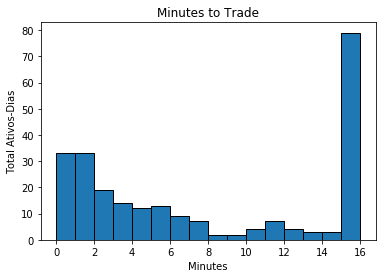

In [27]:
sg.plotHistMinsToTrade()

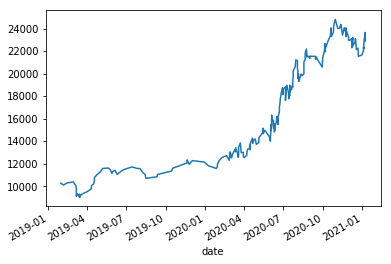

In [28]:
sg.plotEquityCurve()

##### Análise de algumas estratificações

In [29]:
dftr = pd.merge(dft,dfd,how='inner',on=['name','date'])
dftr = dftr[['name','date','gap','factorF','profit','cum_profit']]
dftr

,name,date,gap,factorF,profit,cum_profit
0,CODX,2019-01-30,1.904267,0.266713,0.300000,1.030000
1,AMRS,2019-02-05,0.380952,0.076067,-0.141066,1.015470
2,SOLO,2019-02-14,0.307235,0.228733,0.215969,1.037401
3,RKDA,2019-02-28,0.518727,1.407883,0.097624,1.047529
4,BPTH,2019-03-06,0.609071,4.109809,-0.300000,1.016103
...,...,...,...,...,...,...
239,CHEK,2021-01-05,0.655172,2.017858,0.300000,3.797614
240,NCTY,2021-01-07,0.474185,9.610860,0.300000,3.911543
241,XNET,2021-01-07,0.267574,0.119005,-0.057685,3.888979
242,GRNQ,2021-01-08,0.346756,0.503378,0.184536,3.960745


In [30]:
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
gap = np.clip( dftr['gap'], bins[0], bins[-1] )
dftr.groupby(pd.cut(gap, bins)).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

,winrate,lossrate,mean,mean_of_pos,mean_of_neg,count,positives,negatives
gap,,,,,,,,
"(0.2, 0.3]",0.644068,0.355932,0.037734,0.133082,-0.134800,59,38.0,21.0
"(0.3, 0.4]",0.545455,0.454545,0.012906,0.169811,-0.175381,22,12.0,10.0
"(0.4, 0.5]",0.645161,0.354839,0.069954,0.231503,-0.223771,31,20.0,11.0
"(0.5, 0.6]",0.769231,0.230769,0.085115,0.199012,-0.294543,26,20.0,6.0
"(0.6, 0.7]",0.650000,0.350000,0.053699,0.224920,-0.264284,20,13.0,7.0
"(0.7, 0.8]",0.583333,0.416667,0.020771,0.221339,-0.260024,12,7.0,5.0
"(0.8, 0.9]",0.833333,0.166667,0.127924,0.213509,-0.300000,12,10.0,2.0
"(0.9, 1.0]",0.750000,0.250000,0.114196,0.239130,-0.260606,4,3.0,1.0
"(1.0, 1.1]",0.750000,0.250000,0.102443,0.236590,-0.300000,8,6.0,2.0


In [31]:
dftr.groupby(dftr['date'].dt.to_period('M')).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

,winrate,lossrate,mean,mean_of_pos,mean_of_neg,count,positives,negatives
date,,,,,,,,
2019-01,1.000000,0.000000,0.300000,0.300000,NaN,1,1.0,0.0
2019-02,0.666667,0.333333,0.057509,0.156796,-0.141066,3,2.0,1.0
2019-03,0.333333,0.666667,-0.100000,0.300000,-0.300000,9,3.0,6.0
2019-04,1.000000,0.000000,0.269225,0.269225,NaN,7,7.0,0.0
2019-05,0.666667,0.333333,0.065971,0.189266,-0.180620,6,4.0,2.0
2019-06,0.750000,0.250000,0.076613,0.202150,-0.300000,4,3.0,1.0
2019-07,0.500000,0.500000,0.057530,0.207883,-0.092823,2,1.0,1.0
2019-08,0.200000,0.800000,-0.133862,0.014028,-0.170835,5,1.0,4.0
2019-09,1.000000,0.000000,0.180041,0.180041,NaN,2,2.0,0.0


##### Analisando o Dataframe com extra statistics

In [32]:
# aqui podemos fazer alguma análise, basta fazer inner join de dfes com os outros dataframes dfd, dft
dfes

,name,date,open_pre,high_pre,low_pre,close_pre,open_core,high_core,low_core,close_core
0,CODX,2019-01-30,1.15,3.3800,1.15,3.20,3.2400,3.77,2.11,2.2300
1,AMRS,2019-02-05,3.48,5.4899,3.48,4.37,4.3500,5.84,4.06,5.4600
2,SOLO,2019-02-14,5.60,6.6500,5.15,5.71,5.6700,6.74,4.57,4.8900
3,GEVO,2019-02-27,2.72,3.9500,2.72,3.06,3.0600,3.14,2.41,2.4600
4,RKDA,2019-02-28,5.85,9.7000,5.85,8.11,8.1100,10.40,6.93,8.0501
...,...,...,...,...,...,...,...,...,...,...
467,XNET,2021-01-07,4.19,4.7800,4.14,4.26,4.2844,5.82,3.95,4.9847
468,OXFD,2021-01-07,21.89,22.1600,21.76,21.95,21.9500,22.01,21.80,21.8750
469,CBAT,2021-01-07,7.00,9.3500,6.45,8.75,8.7700,8.80,7.31,7.7100
470,GRNQ,2021-01-08,2.35,3.2800,2.23,3.01,3.0100,3.73,2.40,2.7000


##### Rodando Bootstrap

In [ ]:
bss.runBootstrap()

In [ ]:
sg.printBootstrapResults()

##### Códigos para rodar combinações de parâmetros e otimizar.

In [ ]:
# oficial que gostaríamos de explorar
os.runSimulationGroup(
    prevol_threshold = [800000],
    exit_target=[0.1, 0.2, 0.3, 0.4], 
    exit_stop=[0.1, 0.2, 0.3, 0.4], 
    short_after=[0, 0.1, 0.2, 0.3],
    gap_threshold=[0, 0.1, 0.2],
    F_high_threshold = [1,2,3,4,5]
)

In [ ]:
# rodar para debugar
os.runSimulationGroup(
    prevol_threshold = [15000000],
    exit_target=[0.2, 0.3], 
    exit_stop=[0.3], 
    short_after=[0, 0.1],
    gap_threshold=[0.1],
    F_high_threshold = [1]
)

In [ ]:
# sg.saveGroupResults('teste1.pkl')
sg.appendGroupResults('teste1.pkl')
# sg.openGroupResults('teste1.pkl')

In [ ]:
sg.groupResults

##### Descrição simulações já rodadas

##### Testes temporários em geral. Desconsiderar essa parte do notebook.

In [ ]:
import datetime

In [ ]:
intra = Ativo.initIntradayFromDate('ABUS',fm['ABUS'],datetime.date(2020, 7, 24), sg)

In [ ]:
%%time
day = Ativo('ABUS', fm['ABUS'], sg)

In [ ]:
#day.data
day.data[0]

In [ ]:
intra

In [ ]:
x = Ativo.openIntraDataWithDB('ABUS',datetime.date(2020, 7, 24))

In [ ]:
x[0]['time'].date()

In [ ]:
intra

In [ ]:
len(names_pennystocks)

In [ ]:
len(names_free_float)

In [ ]:
names = list(set(names_pennystocks) & set(names_free_float))

In [ ]:
len(names)

In [ ]:
intra = Ativo.initIntradayFromDate('AIM',fm,datetime.date(2020, 2, 28), sg)

In [ ]:
intra

In [ ]:
len(ativo_dia_list)

In [ ]:
len(sim.fad)